## Potato disease Clacification problem
### dataset is from https://www.kaggle.com/arjuntejaswi/plant-village

In [16]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [17]:
Img_size = 256
Batch_size = 32

In [18]:
#Generates a tf.data.Dataset from image files in a directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\Data_Science_Projects\Datasets\Potato_dataset", 
    shuffle = True,
    image_size = (Img_size,Img_size),
    batch_size = Batch_size
    
)

Found 2152 files belonging to 3 classes.


In [19]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [20]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 2 1 0 1 1 2 0 0 0 1 0 0 0 0 2 0 0 0 1 1 1 2 0 1 0 1 1 0 1 1]


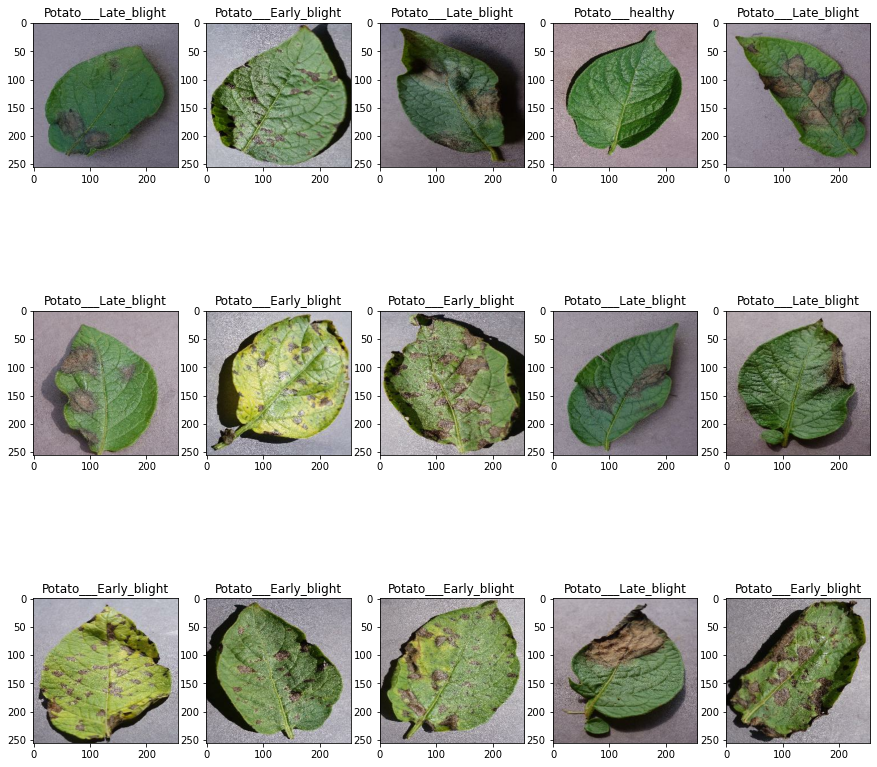

In [7]:
plt.figure(figsize = (15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy()/255)
        plt.title(class_names[label_batch[i]])

In [21]:
len(dataset)

68

In [9]:
14

14

In [22]:
#splite train, validaton, test  dataset
def get_train_test_validation_set_tf(dataset, train_split_size = 0.8, validation_split_size= 0.1, test_split_size= 0.1, shuffle = True, shuffle_size = 1000):
    
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = 10) #seed is for ReSampler** for preditibility. representing the random seed that will be used to create the distribution
        
    train_size = int(dataset_size * train_split_size)
    validation_size = int(dataset_size * validation_split_size)
    
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)
    
    
    
    return train_dataset, validation_dataset, test_dataset

In [23]:
train_dataset, validation_dataset, test_dataset = get_train_test_validation_set_tf(dataset)

In [24]:
#cache if for avoid redundancy and prefetch is for optimize cpu and gpu
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [25]:
#preprocessing
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Img_size,Img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [26]:
no_of_classes = 3


model = models.Sequential([
    resize_rescale,
    data_aug,
    
    #convolution layers
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape = (Batch_size,Img_size, Img_size,3)), #input shape is defined as (batch_size, Img_size, Img_size, Channels)
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    #flattern and dense layer
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(no_of_classes, activation = 'softmax'),
])

model.build(input_shape = (Batch_size,Img_size, Img_size,3))

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [28]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_dataset, 
    epochs = 20, 
    batch_size = Batch_size,
    verbose = 1,
    validation_data = validation_dataset,
)

Epoch 1/20
54/54 [==============================] - 80s 1s/step - loss: 0.8875 - accuracy: 0.4818 - val_loss: 0.9610 - val_accuracy: 0.4688
Epoch 2/20
54/54 [==============================] - 53s 988ms/step - loss: 0.7214 - accuracy: 0.6461 - val_loss: 1.0936 - val_accuracy: 0.5729
Epoch 3/20
54/54 [==============================] - 53s 990ms/step - loss: 0.3986 - accuracy: 0.8404 - val_loss: 0.1757 - val_accuracy: 0.9479
Epoch 4/20
54/54 [==============================] - 52s 972ms/step - loss: 0.2262 - accuracy: 0.9143 - val_loss: 0.3283 - val_accuracy: 0.8594
Epoch 5/20
54/54 [==============================] - 53s 987ms/step - loss: 0.1183 - accuracy: 0.9513 - val_loss: 0.6191 - val_accuracy: 0.8177
Epoch 6/20
54/54 [==============================] - 53s 980ms/step - loss: 0.1270 - accuracy: 0.9531 - val_loss: 0.2269 - val_accuracy: 0.9271
Epoch 7/20
54/54 [==============================] - 53s 987ms/step - loss: 0.1422 - accuracy: 0.9413 - val_loss: 0.5801 - val_accuracy: 0.7969
Ep

In [30]:
model.evaluate(test_dataset)

8/8 [==============================] - 5s 314ms/step - loss: 0.3295 - accuracy: 0.8828


[0.32950350642204285, 0.8828125]

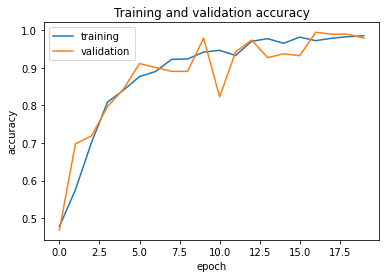

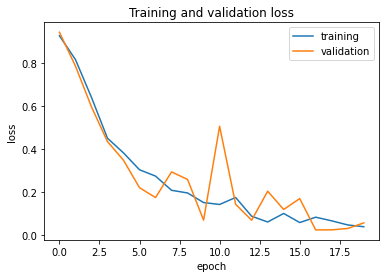

In [60]:
plt.plot(range(20),history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [113]:
#confution matrix to see how my model work
actual = []
predict = []
#for all test images 
for image_batch, label_batch in test_dataset:
    for i in label_batch.numpy():
        actual.append(i)
    for i in range(len(image_batch.numpy())):
        predict.append(np.argmax(model.predict(image_batch)[i]))


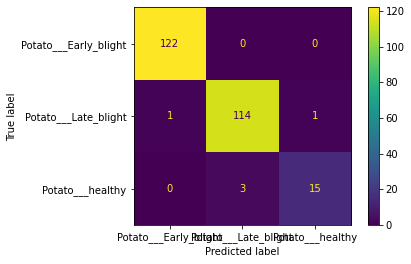

In [114]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(actual, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= class_names)
disp.plot()
plt.show()



In [122]:
#save the model
version = 1
model.save(f"models/{version}")

KeyError: "Failed to add concrete function 'b'__inference_sequential_3_layer_call_fn_330962'' to object-based SavedModel as it captures tensor <tf.Tensor: shape=(), dtype=resource, value=<Resource Tensor>> which is unsupported or not reachable from root. One reason could be that a stateful object or a variable that the function depends on is not assigned to an attribute of the serialized trackable object (see SaveTest.test_captures_unreachable_variable)."

In [15]:
model = tf.keras.models.load_model("C:\Data_Science_Projects\Potato_Disease_Classification\saved_models")
tf.saved_model.save(model, "C:\Data_Science_Projects\Potato_Disease_Classification\nn")

OSError: SavedModel file does not exist at: C:\Data_Science_Projects\Potato_Disease_Classification\saved_models\{saved_model.pbtxt|saved_model.pb}